<a href="https://colab.research.google.com/github/SvourenosMichail/car-and-lane-detection/blob/main/car_detector_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import libraries
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2
import pandas as pd
import random
import matplotlib.patches as patches
import glob
import xml.etree.ElementTree as ET
import os
from tqdm.auto import tqdm
import shutil
import yaml
import math
from google.colab.patches import cv2_imshow

In [ ]:
# clone yolov5 model
!git clone https://github.com/ultralytics/yolov5

In [ ]:
#load load yolov5 model
model = torch.hub.load('ultralytics/yolov5','yolov5s')

In [ ]:
#download koaggle dataset
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

!kaggle datasets download -d sshikamaru/car-object-detection
!unzip /content/car-object-detection.zip

In [ ]:
#reads kaggle data - returns train_boxes as panda df
def read_kaggle_data():
  train_boxes = pd.read_csv('/content/data/train_solution_bounding_boxes (1).csv')
  train_boxes['image'] = train_boxes['image'].apply(lambda x: x.split('.')[0]) 
  return train_boxes

#print a random training img
def print_rand_image():
  index = list(train_boxes.index) 
  image_idx = random.choice(index) 
  image = train_boxes.iloc[image_idx]["image"] #integer indexing
  img = cv2.imread(f"../content/data/training_images/{image}.jpg") #read image
  img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB) #fix colours
  fig, ax = plt.subplots(figsize=(10,10)) 

  min_point = (train_boxes.iloc[image_idx]["xmin"], train_boxes.iloc[image_idx]["ymin"])
  w = train_boxes.iloc[image_idx]["xmax"] - min_point[0]
  h = train_boxes.iloc[image_idx]["ymax"] - min_point[1]
  rect = patches.Rectangle(min_point, w, h, linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)  
  ax.imshow(img)
  plt.title(image)
  ax.axis('off')
  return img

def convert_to_yolo_format(train_boxes):
  train_boxes['x_center'] = (train_boxes['xmin'] + train_boxes['xmax'])/2
  train_boxes['y_center'] = (train_boxes['ymin'] + train_boxes['ymax'])/2
  train_boxes['w'] = train_boxes['xmax'] - train_boxes['xmin']
  train_boxes['h'] = train_boxes['ymax'] - train_boxes['ymin']
  train_boxes['classes'] = 0

  img_h,img_w,ch = img.shape
  train_boxes['x_center'] = train_boxes['x_center']/img_w
  train_boxes['w'] = train_boxes['w']/img_w
  train_boxes['y_center'] = train_boxes['y_center']/img_h
  train_boxes['h'] = train_boxes['h']/img_h
  print(train_boxes)
  return train_boxes

def split_sets(train_boxes,val_ratio):
  val_index = list(train_boxes.index)[train_boxes.shape[0] - int(train_boxes.shape[0]*val_ratio):]
  val_names = train_boxes.iloc[val_index]["image"].values
  return val_names


In [ ]:
train_boxes = read_kaggle_data()

In [ ]:
img = print_rand_image()

In [ ]:
convert_to_yolo_format(train_boxes)

In [ ]:
val_names = split_sets(train_boxes,0.1)

In [ ]:
train_label_dir = "preprocessed_dataset/train/labels/"
val_label_dir = "preprocessed_dataset/val/labels/"
os.makedirs(train_label_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)

train_image_dir = "preprocessed_dataset/train/images/"
val_image_dir = "preprocessed_dataset/val/images/"
os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(val_image_dir, exist_ok=True)

In [ ]:
source = 'training_images'
for name,mini in tqdm(train_boxes.groupby("image")):
    if name in val_names:
        path2save_label = val_label_dir
        path2save_image = val_image_dir
    else:
        path2save_label = train_label_dir
        path2save_image = train_image_dir
        
    with open(path2save_label + name+".txt", 'w+') as f:
        row = mini[['classes','x_center','y_center','w','h']].astype(float).values
        row = row.astype(str)
        for j in range(len(row)):
            text = ' '.join(row[j])
            f.write(text)
            f.write("\n")
            
    shutil.copy("../content/data/{}/{}.jpg".format(source,name),
                "{}{}.jpg".format(path2save_image,name))

In [ ]:
classes = ['car']
config = {'path': '/content/preprocessed_dataset',
         'train': '/content/preprocessed_dataset/train',
         'val': '/content/preprocessed_dataset/val',
         'nc': len(classes),
         'names': classes}
 
with open("dataset.yaml", "w") as file:
    yaml.dump(config, file, default_flow_style=False)

start of second dataset 
/
/
/
/


end of second dataset////

In [ ]:
!cd yolov5 && python train.py --img 676 --batch 16 --epochs 40 --data dataset.yaml --weights yolov5s.pt

train: weights=yolov5s.pt, cfg=, data=dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=40, batch_size=16, imgsz=676, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-71-gc442a2e Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, 

In [ ]:
#!cd yolov5 && python train.py --img 676 --batch 16 --epochs 300 --data dataset.yaml --weights yolov5s.pt

In [ ]:
model = torch.hub.load('ultralytics/yolov5','custom',path='/content/yolov5/runs/train/exp2/weights/best.pt',force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-1-19 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
#converts line into 2 points (x1,y1) (x2,y2)
def make_coordinates(image,line_parameters):
    slope,intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*(3/5))
    x1 = int((y1-intercept)/slope)
    x2 = int((y2-intercept)/slope)
    return np.array([x1,y1,x2,y2])


#finds acceptable lines and averages them out. Returns left and right lane line.
#If one lane side is not detected and expected line is created.
def average_slope(image,lines):
    left_lines = []
    right_lines = []
    final = []
    for line in lines:
        x1,y1,x2,y2 = line.reshape(4)
        myradians = math.atan2(y1-y2, x1-x2)
        mydegrees = math.degrees(myradians)
        angle = abs(mydegrees)
        thr = abs(angle-180)  #threshold, the angle of the current line. Only lines with thr > 15 get accepted as possible lines for the road edge. 
                              #Filters out lines caused by shadows or noise.
        
        parameters = np.polyfit((x1,x2),(y1,y2),1)
        slope = parameters[0]
        intercept = parameters[1]
        if thr>15:
          if mydegrees < 0:
              left_lines.append((slope,intercept))
          else:
              right_lines.append((slope,intercept))
    print('len left: ',len(left_lines),' len right: ',len(right_lines))

    #if no lane side is found
    if len(left_lines)==0 and len(right_lines)==0:
      print('0 lines found')
      print(len(final))
      return final
    
    #if both lane sides are found 
    if len(left_lines)!=0 and len(right_lines) != 0:
      left_lines_avg = np.average(left_lines,axis=0)
      left_line = make_coordinates(image,left_lines_avg)
      final.append(left_line)

      right_lines_avg = np.average(right_lines,axis=0)
      right_line = make_coordinates(image,right_lines_avg)
      final.append(right_line)
      print('2 lines found')
      print(len(final))
      return final
    
    #if only 1 side is found the other one is created with an expected position
    if len(left_lines) != 0:
      print('added left line')
      left_lines_avg = np.average(left_lines,axis=0)
      left_line = make_coordinates(image,left_lines_avg)
      x1,y1,x2,y2 = left_line.reshape(4)
      final.append(left_line)
      final.append([x1-1150,y1,x2-140,y2])
    else:
      print('added right line')
      right_lines_avg = np.average(right_lines,axis=0)
      right_line = make_coordinates(image,right_lines_avg)
      x1,y1,x2,y2 = right_line.reshape(4)
      final.append([x1+1100,y1,x2+160,y2])
      final.append(right_line)
    print(len(final))
    return final

#converts image into one that only shows edges
def edge_detection(image):
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY) #convert to greyscale
    blur = cv2.GaussianBlur(gray,(5,5),0) #reduce noise
    edge_img = cv2.Canny(blur,50,150) #with derivative of f(x,y) it finds areas where there is gradient >50
    return edge_img

#prints the lane edges onto the image
def display_lines(image,lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
          print(line)
          x1,y1,x2,y2 = line
          cv2.line(line_image,(x1,y1),(x2,y2),(0,125,0),10)

    return line_image

#cut out the part of the image that interests us
def region_of_interest(image):
    height = image.shape[0]
    triangle = np.array([
        [(320,500),(1200,500),(747,400)] #hardcoded-our region of interest-represents the expected location of the road/lane 
    ])
    triangle = triangle.astype(np.int32)
    
    mask = np.zeros_like(image)

    cv2.fillPoly(mask,triangle,255)
    masked_image = cv2.bitwise_and(image,mask)
    return masked_image



len left:  2  len right:  0
added left line
2
[1363  715  823  429]
[213, 715, 683, 429]


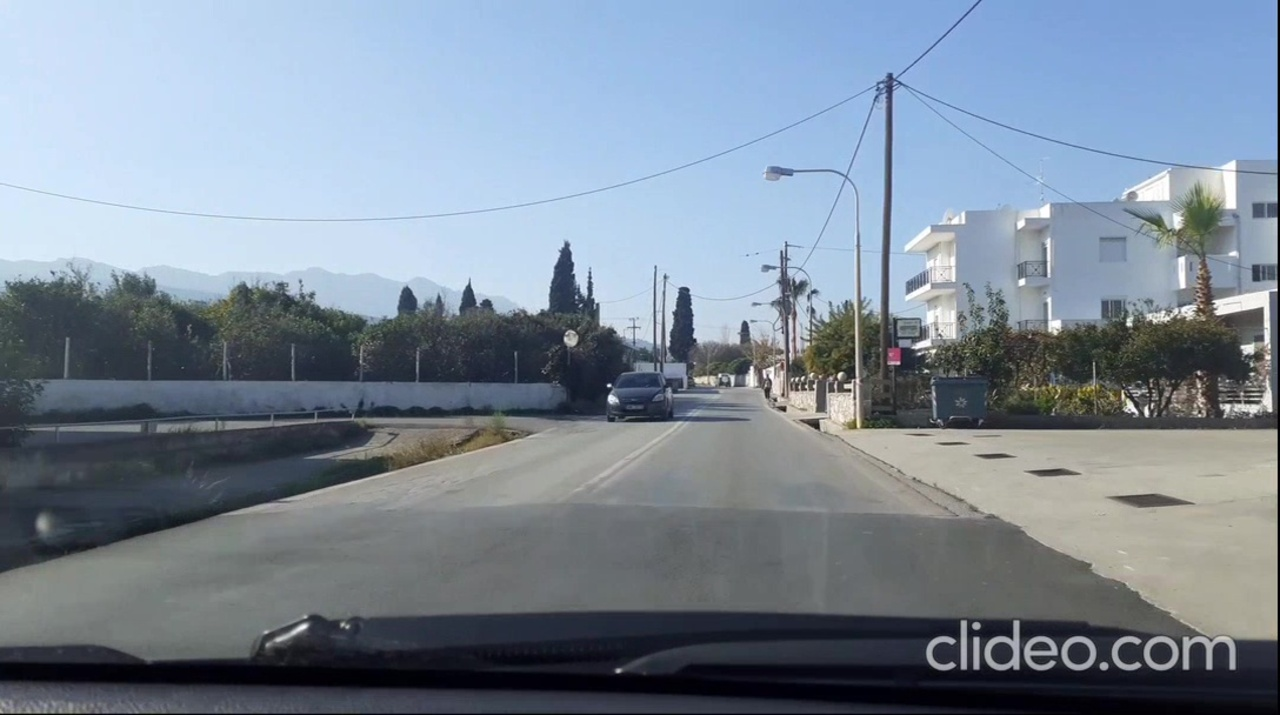

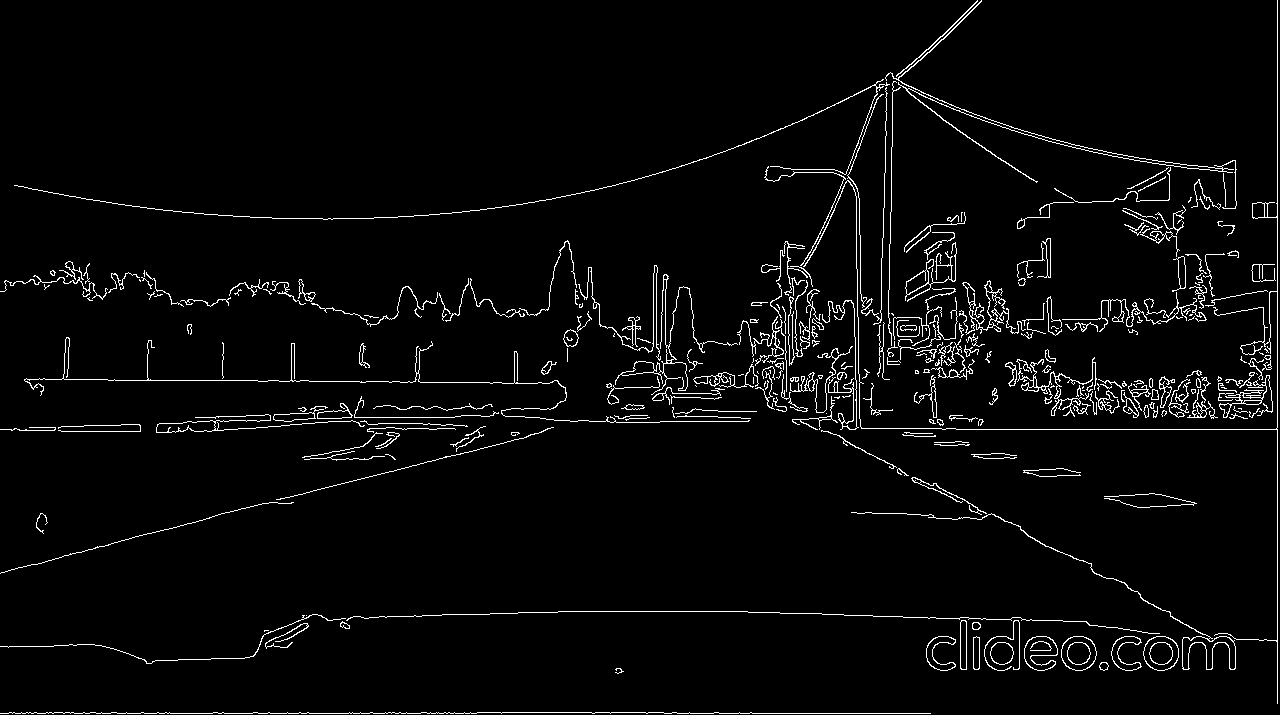

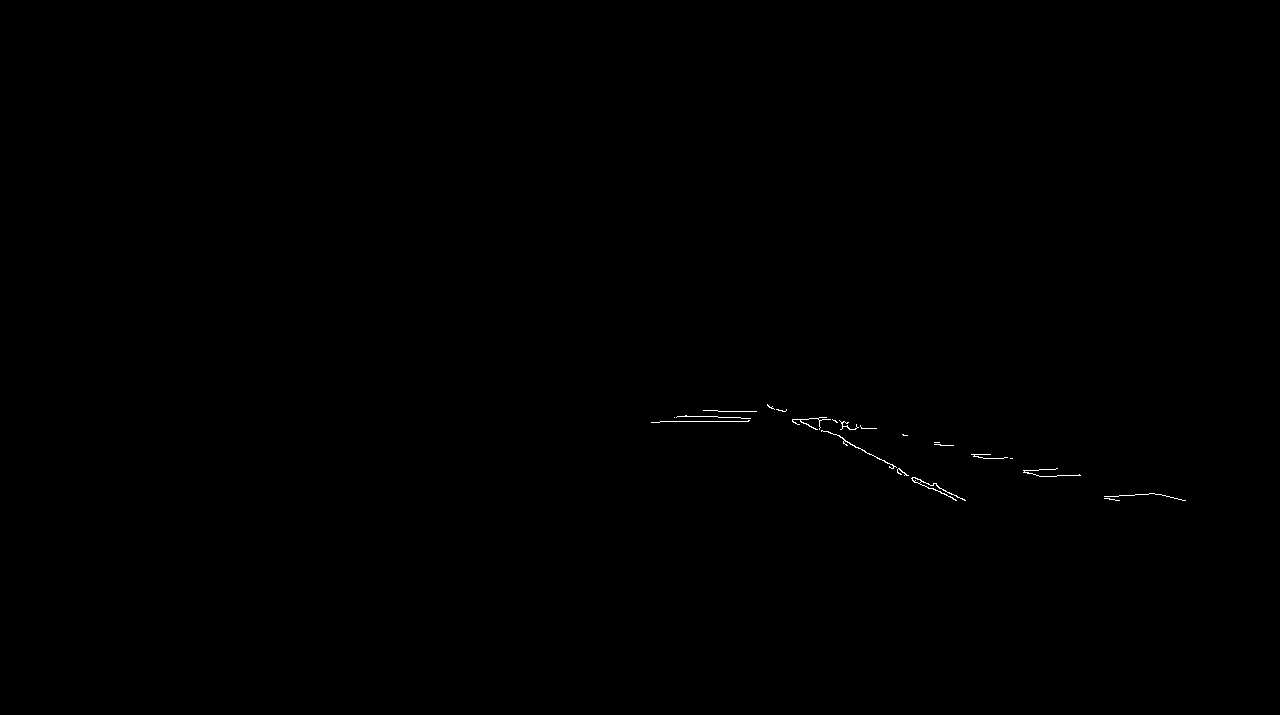

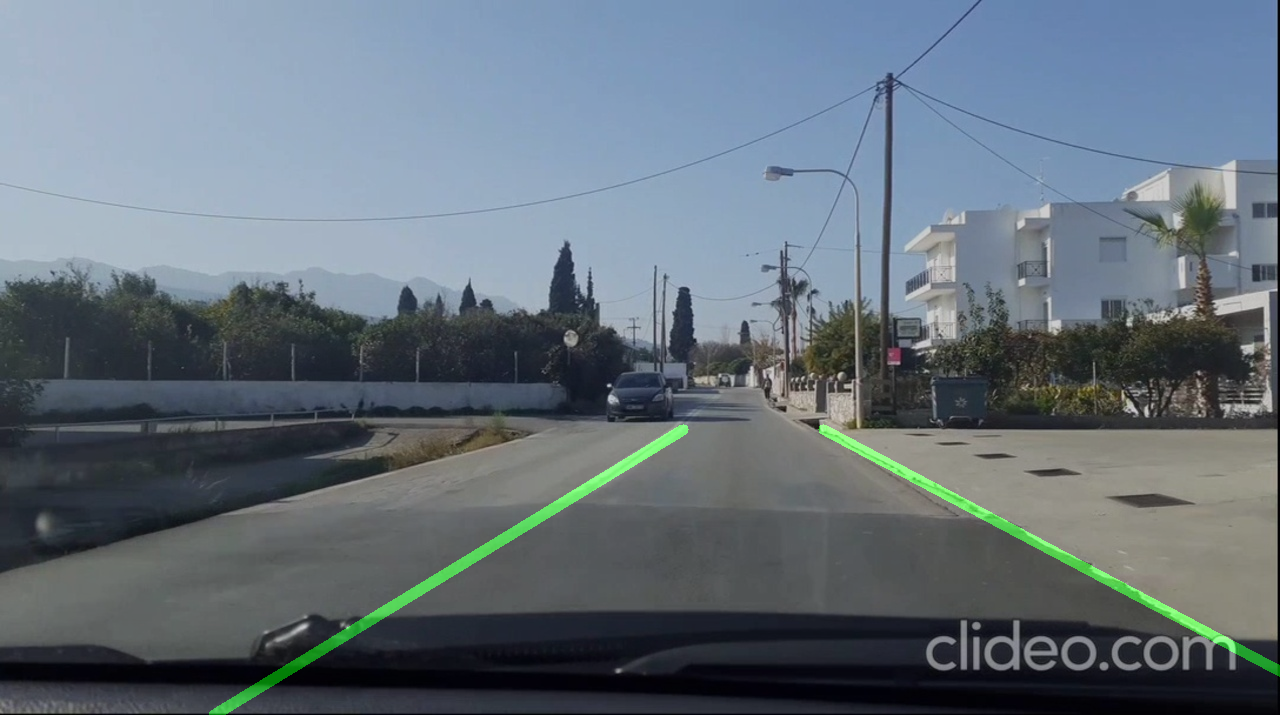

In [ ]:
img = '/content/scene00021.jpg'
image = cv2.imread(img)
lane_image = np.copy(image)
edge_image = edge_detection(lane_image)
cropped_image = region_of_interest(edge_image)
lines = cv2.HoughLinesP(cropped_image,2,math.pi/180,50,np.array([]),minLineLength=40,maxLineGap=5)
averaged_lines = average_slope(lane_image,lines)
line_image = display_lines(lane_image,averaged_lines)
combo_image = cv2.addWeighted(lane_image,0.8,line_image,1,1)
cv2_imshow(image)
cv2_imshow(edge_image)
cv2_imshow(cropped_image)
cv2_imshow(combo_image)

In [ ]:
results = model(combo_image)
results.print()

image 1/1: 715x1280 1 car
Speed: 4.5ms pre-process, 16.7ms inference, 1.7ms NMS per image at shape (1, 3, 384, 640)


In [ ]:
rect = results.pandas().xyxy[0]  # im predictions (pandas)
detections = rect.shape[0]

In [ ]:
final_image = combo_image

In [ ]:
#y_distance has the y positions in the image that represent the 5,10,15,20 etc meter distances from the car. 
#example: y_distance[0] represents 0 meters distance from car, y_distance[1] represents 5 meters distance from car etc.
y_distance = [715,530,450,420,400,390,385]

for detection in range(detections):
  count = 0
  #draw the rectangle around the car
  x1= int(rect.iloc[detection][0])
  y1= int(rect.iloc[detection][1])
  x2= int(rect.iloc[detection][2])
  y2= int(rect.iloc[detection][3])
  cv2.rectangle(final_image,(x1,y1),(x2,y2),(0,255,0),2)

  #calculate exact distance 
  for entry in y_distance:
    
    if y2 > entry:
      margin = y_distance[count-1]-y_distance[count]  #distance in pixels between 2 thresholds
      car_margin = y_distance[count-1]-y2 #distance of car from threshold bottom
      percent = car_margin/margin #used to calculate the exact position of the car in threshold
      text = str( round(((count-1)*5)+5*percent,1))+' meters'
      break
    count+=1
  
  cv2.putText(final_image,text, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

In [ ]:
def isLeft(lines,x,y):
  if lines is not None:
    for line in lines:
      print(line)
      x1,y1,x2,y2 = line
      print(((x2 - x1)*(y - y1) - (y2 - y1)*(x - x1)) > 0)


In [ ]:
x = int((x1+x2)/2)
y = int((y1+y2)/2)
print(isLeft(averaged_lines,x,y))

[1363  715  823  429]
False
[213, 715, 683, 429]
False
None


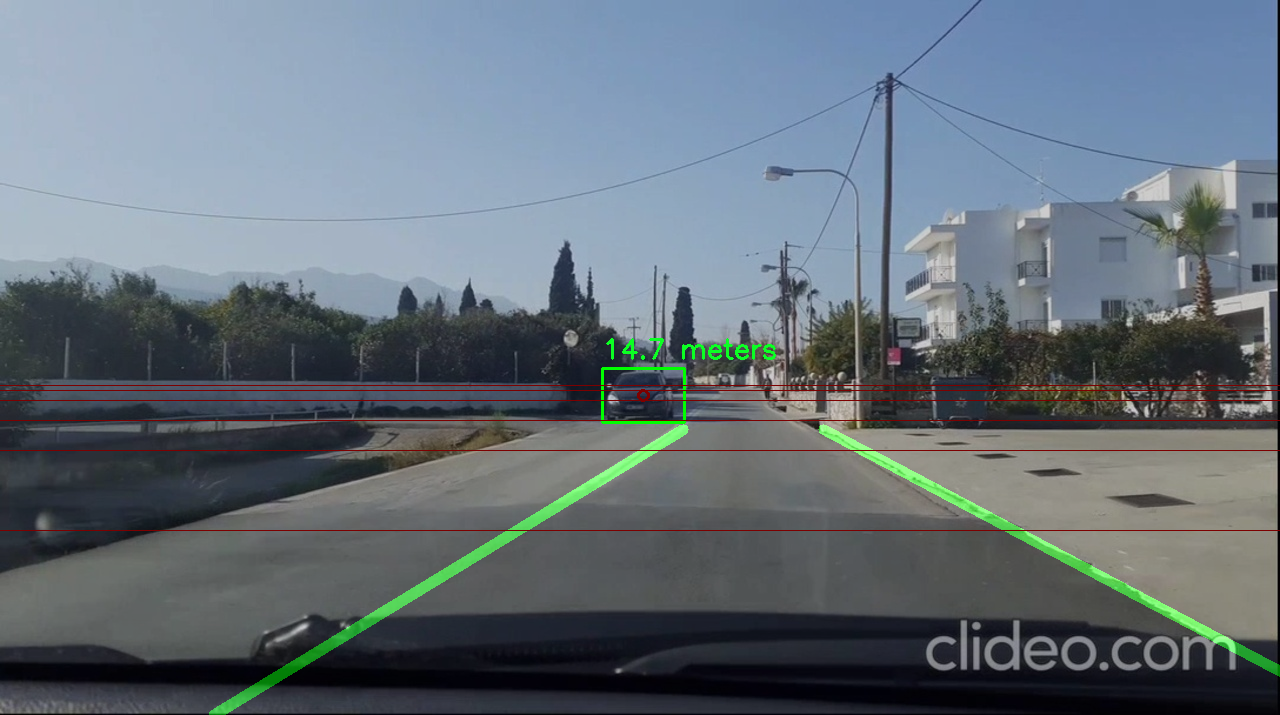

In [ ]:
width = image.shape[1]
for dis in y_distance:
  cv2.line(final_image,(0,dis),(width,dis),(0,0,125),1)
final_image = cv2.circle(final_image, (x,y), 5, (0,0,125), 2)
cv2_imshow(final_image)